<a href="https://colab.research.google.com/github/yacinmansour161-sudo/Malaria-Detection/blob/main/last_chance_malariya_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.9.0+cu126
0.24.0+cu126


In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\r\n  "username": "yassou IA",\r\n  "key": "KGAT_ad8ac65fdf179a0f07e278e4c62e83a7"\r\n}\r\n'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip cell-images-for-detecting-malaria.zip


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87

In [5]:
import shutil
import os

duplicate_path = "cell_images/cell_images"

if os.path.exists(duplicate_path):
    shutil.rmtree(duplicate_path)
    print("✅ Dossier dupliqué supprimé")
else:
    print("ℹ️ Aucun dossier dupliqué trouvé")


✅ Dossier dupliqué supprimé


In [6]:
os.listdir("cell_images")


['Parasitized', 'Uninfected']

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [9]:
import os

os.listdir("/content")
os.listdir("/content/cell_images")


['Parasitized', 'Uninfected']

In [10]:
import os
import shutil
import random

SOURCE_DIR = "cell_images"
TARGET_DIR = "data"

SPLITS = {
    "train": 0.7,
    "val": 0.15,
    "test": 0.15
}

CLASSES = ["Parasitized", "Uninfected"]

random.seed(42)

for cls in CLASSES:
    images = os.listdir(os.path.join(SOURCE_DIR, cls))
    random.shuffle(images)

    n = len(images)
    train_end = int(SPLITS["train"] * n)
    val_end = train_end + int(SPLITS["val"] * n)

    split_images = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, imgs in split_images.items():
        split_dir = os.path.join(TARGET_DIR, split, cls)
        os.makedirs(split_dir, exist_ok=True)

        for img in imgs:
            shutil.copy(
                os.path.join(SOURCE_DIR, cls, img),
                os.path.join(split_dir, img)
            )

print("✅ Split train/val/test terminé")


✅ Split train/val/test terminé


In [11]:
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}")
    for cls in CLASSES:
        path = f"data/{split}/{cls}"
        print(cls, ":", len(os.listdir(path)))



TRAIN
Parasitized : 9646
Uninfected : 9646

VAL
Parasitized : 2067
Uninfected : 2067

TEST
Parasitized : 2067
Uninfected : 2067


In [12]:
train_dataset = datasets.ImageFolder("data/train", transform=train_transform)
val_dataset   = datasets.ImageFolder("data/val", transform=val_test_transform)
test_dataset  = datasets.ImageFolder("data/test", transform=val_test_transform)


In [13]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


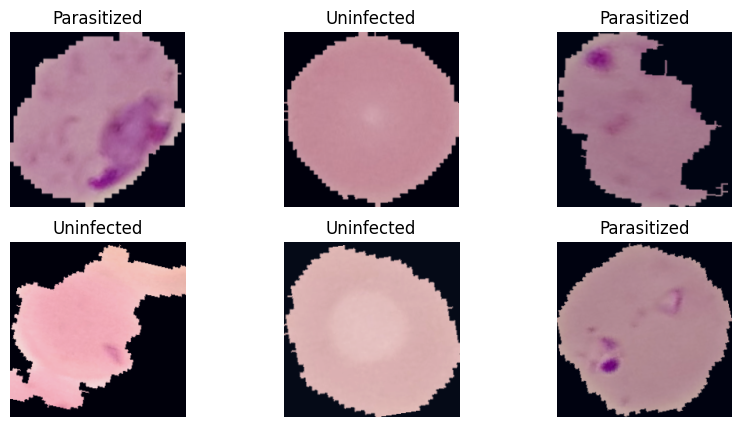

In [14]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    img = images[i].permute(1,2,0)
    img = img * 0.225 + 0.45  # dé-normalisation approx
    plt.imshow(img.clamp(0,1))
    plt.title(train_dataset.classes[labels[i]])
    plt.axis("off")
plt.show()


In [15]:
import torch.nn as nn
import torch.nn.functional as F
class MalariaCNN(nn.Module):
    def __init__(self):
        super(MalariaCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 2)  # 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MalariaCNN().to(device)
print(model)


MalariaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [17]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)
print(output.shape)


torch.Size([1, 2])


In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
from tqdm import tqdm

NUM_EPOCHS = 10
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    # --- Entraînement ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    # --- Validation ---
    model.eval()
    val_corrects = 0
    val_total = 0


    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels)
            val_total += labels.size(0)

    val_acc = val_corrects.double() / val_total
    print(f"Val Acc: {val_acc:.4f}")
    val_accs.append(val_acc.item())

    # Sauvegarde du meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_malaria_cnn.pth")
        print("💾 Nouveau meilleur modèle sauvegardé !")


Epoch 1/10: 100%|██████████| 603/603 [01:20<00:00,  7.45it/s]

Train Loss: 0.6015 | Train Acc: 0.6848


Val Acc: 0.8171
💾 Nouveau meilleur modèle sauvegardé !


Epoch 2/10: 100%|██████████| 603/603 [01:20<00:00,  7.53it/s]

Train Loss: 0.3939 | Train Acc: 0.8523


Val Acc: 0.9131
💾 Nouveau meilleur modèle sauvegardé !


Epoch 3/10: 100%|██████████| 603/603 [01:18<00:00,  7.64it/s]

Train Loss: 0.2607 | Train Acc: 0.9075


Val Acc: 0.9202
💾 Nouveau meilleur modèle sauvegardé !


Epoch 4/10: 100%|██████████| 603/603 [01:22<00:00,  7.30it/s]

Train Loss: 0.2161 | Train Acc: 0.9260


Val Acc: 0.9310
💾 Nouveau meilleur modèle sauvegardé !


Epoch 5/10: 100%|██████████| 603/603 [01:22<00:00,  7.35it/s]

Train Loss: 0.2016 | Train Acc: 0.9296


Val Acc: 0.9385
💾 Nouveau meilleur modèle sauvegardé !


Epoch 6/10: 100%|██████████| 603/603 [01:18<00:00,  7.65it/s]

Train Loss: 0.1907 | Train Acc: 0.9342


Val Acc: 0.9427
💾 Nouveau meilleur modèle sauvegardé !


Epoch 7/10: 100%|██████████| 603/603 [01:20<00:00,  7.53it/s]

Train Loss: 0.1849 | Train Acc: 0.9380


Val Acc: 0.9339


Epoch 8/10: 100%|██████████| 603/603 [01:19<00:00,  7.62it/s]

Train Loss: 0.1807 | Train Acc: 0.9387


Val Acc: 0.9489
💾 Nouveau meilleur modèle sauvegardé !


Epoch 9/10: 100%|██████████| 603/603 [01:19<00:00,  7.63it/s]

Train Loss: 0.1793 | Train Acc: 0.9401


Val Acc: 0.9504
💾 Nouveau meilleur modèle sauvegardé !


Epoch 10/10: 100%|██████████| 603/603 [01:19<00:00,  7.55it/s]

Train Loss: 0.1706 | Train Acc: 0.9432


Val Acc: 0.9393


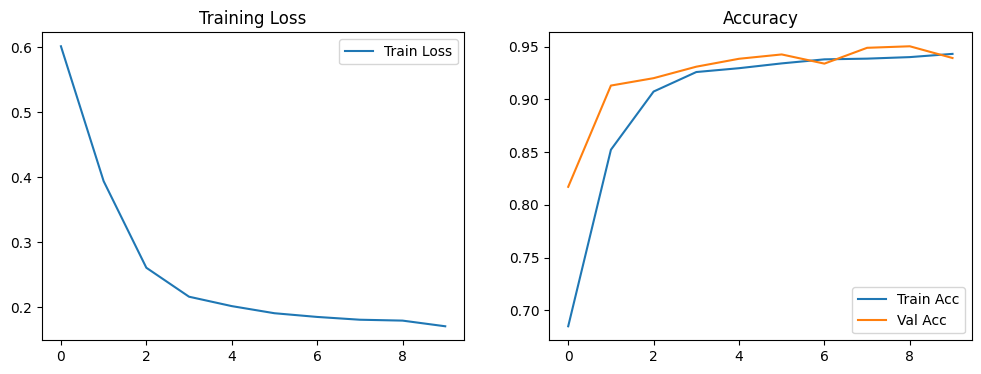

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.show()


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Charger le meilleur modèle
model.load_state_dict(torch.load("best_malaria_cnn.pth"))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Matrice de confusion :")
print(confusion_matrix(y_true, y_pred))
print("\nClassification report :")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


Matrice de confusion :
[[1912  155]
 [  68 1999]]

Classification report :
              precision    recall  f1-score   support

 Parasitized       0.97      0.93      0.94      2067
  Uninfected       0.93      0.97      0.95      2067

    accuracy                           0.95      4134
   macro avg       0.95      0.95      0.95      4134
weighted avg       0.95      0.95      0.95      4134

